In [4]:
from collections import defaultdict
from pyquil.api import SyncConnection as SyncConnection
from referenceqvm.api import SyncConnection as RefSyncConnection
import numpy as np
from pyquil.quil import Program, Gate
from pyquil.quilbase import unpack_qubit
from pyquil.gates import H, CZ, RX, RY
from itertools import product as cartesian_product
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

# Circuits for assignment probability measurements and tomography

In [15]:
from grove.benchmarking.utils import (
    POVM_PI_BASIS,
    make_diagonal_povm, sample_bad_readout, sample_outcomes, basis_state_preps, 
    make_histogram, estimate_assignment_probs
)
from grove.benchmarking.tomography import (StateTomography, ProcessTomography, default_channel_ops,
                                           DEFAULT_STATE_TOMO_SETTINGS, DEFAULT_PROCESS_TOMO_SETTINGS,
                                           default_rotations, state_tomography_programs, process_tomography_programs)

# Estimating bitstring probabilities via histograms

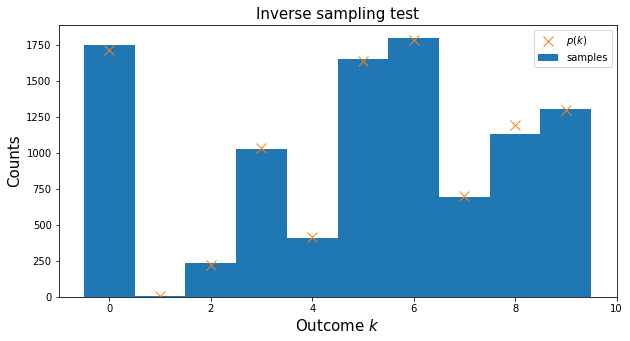

In [3]:
n = 10
N = 10000

probs = np.random.rand(n)
probs /= probs.sum()

samples = sample_outcomes(probs, N)
plt.figure(figsize=(10, 5))
plt.hist(samples, bins=np.arange(n+1)-.5, label="samples")
plt.plot(probs * N, "x", ms=10, label="$p(k)$")
plt.title("Inverse sampling test", size=15)
plt.ylabel("Counts", size=15)
plt.xlabel("Outcome $k$", size=15)
plt.legend(loc="best")


# Simulate bad readout and estimate confusion matrix 

In [9]:
rcxn = RefSyncConnection()

In [12]:
BAD_1Q_READOUT = np.array([[.9, .15],
                           [.1, .85]])

In [13]:

BAD_1Q_READOUT = np.array([[.9, .15],
                           [.1, .85]])
BAD_2Q_READOUT = np.kron(BAD_1Q_READOUT, BAD_1Q_READOUT)

In [21]:
def bitstring_to_int(bitstring):
    "Convert a binary bitstring into the corresponding unsigned integer."
    ret = 0
    for b in bitstring:
        ret = (ret << 1) | (int(b) & 1)
    return ret

In [46]:
import time
def wait_until_done(result):
    if isinstance(result, list):
        return result
    while True:
        if result.is_done(): 
            return result.result['result']
        time.sleep(.1)
        

In [ ]:
class QPUBatch(object):
    
    def __init__(self, args, kwargs):
        self.jobs = []
        self.histograms = []
        
    def save_histograms(self, path):
        
        
    def generate_programs(self):
        raise NotImplementedError()
    
    def results_ready(self):
        return len(self.jobs) > 0 and all(r.is_done() for r in self.jobs)
    
    
    

In [64]:
def sample_assignment_probs(qubits, nsamples, cxn):
    hists = []
    print "Sampling bitstring preparations:"
    # collect readout prep data
    jobs = []
    for jj, p in enumerate(basis_state_preps(*qubits)):
        jobs.append(cxn.run_and_measure(p, qubits, nsamples))
    
    for jj, job in enumerate(jobs):
        print ".",    
        results = wait_until_done(job)
        idxs = map(bitstring_to_int, results)
        hists.append(make_histogram(idxs, d))
    print "done."
    return estimate_assignment_probs(hists)

def do_state_tomography(preparation_program, nsamples, cxn, qubits=None, assignment_probs=None):
    if qubits is None:
        qubits = sorted(preparation_program.extract_qubits())

    nq = len(qubits)
    d = 2**nq
    
    if assignment_probs is None:
        assignment_probs = sample_assignment_probs(qubits, nsamples, cxn)
        
    tomo_seq = list(state_tomography_programs(preparation_program, qubits))
    histograms = np.zeros((len(tomo_seq), d))
    print "Sampling tomographic measurements:"
    jobs = []
    for jj, p in enumerate(tomo_seq):
        jobs.append(cxn.run_and_measure(p, qubits, nsamples))

    for jj, job in enumerate(jobs):
        print ".",
        results = wait_until_done(job)
        idxs = map(bitstring_to_int, results)
        histograms[jj] = make_histogram(idxs, d)
    print "done."
    
    
    povm = make_diagonal_povm(POVM_PI_BASIS ** nq, assignment_probs)
    channel_ops = list(default_channel_ops(nq))
    
    state_tomo = StateTomography.estimate_from_ssr(histograms, povm, channel_ops,
                                                   DEFAULT_STATE_TOMO_SETTINGS)

    return state_tomo, assignment_probs


def do_process_tomography(process, nsamples, cxn, qubits=None, assignment_probs=None):
    if qubits is None:
        qubits = sorted(process.extract_qubits())

    nq = len(qubits)
    d = 2**nq
    
    # 
    if assignment_probs is None:
        assignment_probs = sample_assignment_probs(qubits, nsamples, cxn)
        
    tomo_seq = list(process_tomography_programs(process, qubits))
    histograms = np.zeros((len(tomo_seq), d))
    print "Sampling tomographic measurements:"
    for jj, p in enumerate(tomo_seq):
        print ".",
        results = wait_until_done(cxn.run_and_measure(p, qubits, nsamples))
        
        idxs = map(bitstring_to_int, results)
        histograms[jj] = make_histogram(idxs, d)
    print "done."

    
    povm = make_diagonal_povm(POVM_PI_BASIS ** nq, assignment_probs)
    channel_ops = list(default_channel_ops(nq))
    histograms = histograms.reshape((len(channel_ops), len(channel_ops), d))
    process_tomo = ProcessTomography.estimate_from_ssr(histograms, povm, channel_ops, channel_ops,
                                                   DEFAULT_PROCESS_TOMO_SETTINGS)

    return process_tomo, assignment_probs
    

In [ ]:
cxn = SyncConnection()

Sampling bitstring preparations:
. . . . done.
Sampling tomographic measurements:
. . . . . . . . . . . . . . . . done.


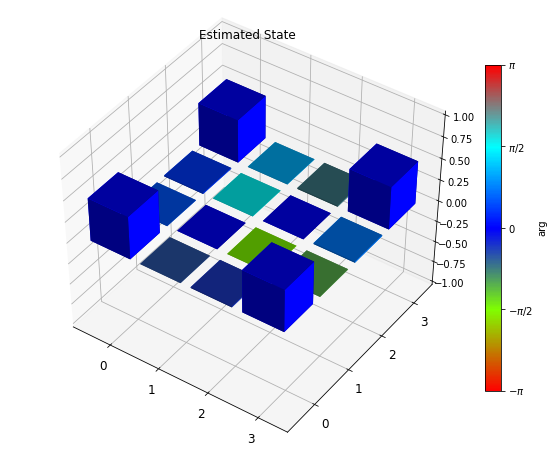

In [48]:
do_state_tomography(Program([H(0), 
                             H(1), CZ(0, 1), H(1)
                            ]), 1000, cxn, [0, 1])

In [55]:
tomo2, ap2 = do_state_tomography(Program([H(0), 
                             H(1), CZ(0, 1), H(1)
                            ]), 10000, qpu, [0, 1])

Sampling bitstring preparations:
. . . . done.
Sampling tomographic measurements:
. . . . . . . . . . . . . . . . done.


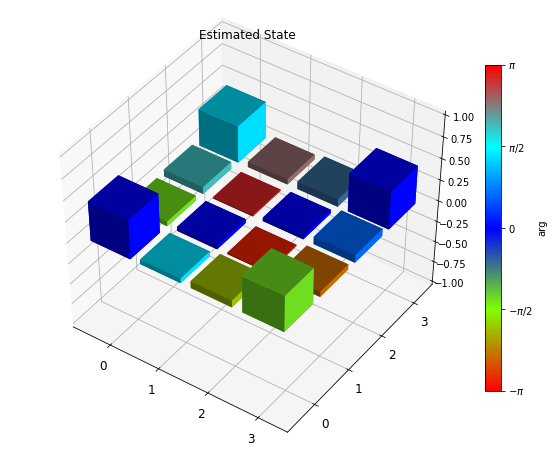

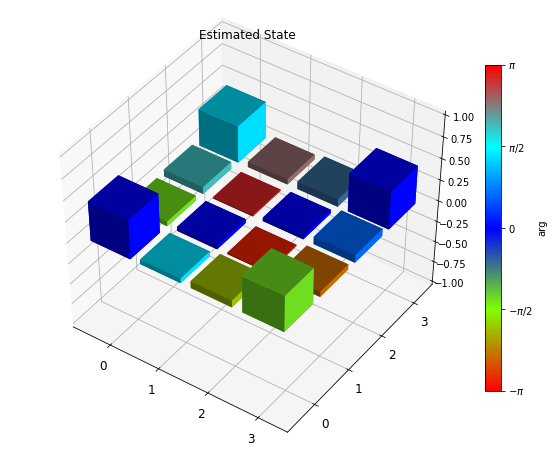

In [59]:
tomo2.plot()

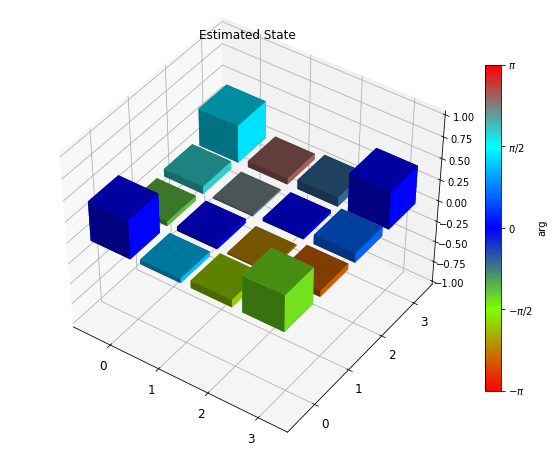

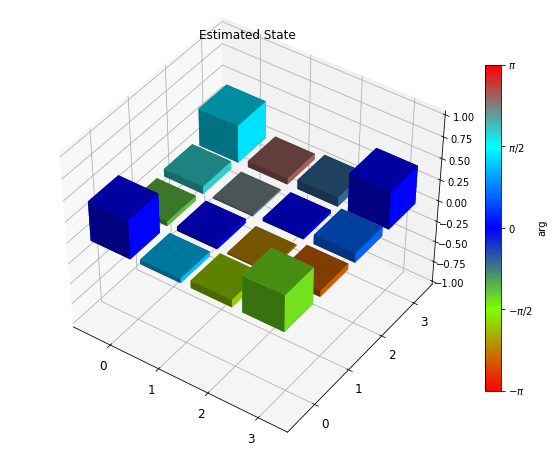

In [60]:
tomo.plot()

In [61]:
tomo.fidelity(tomo2.rho_est)

0.9930997221550978

In [50]:
qpu2 = QPUConnection(endpoint='https://job.rigetti.com/beta',
                    api_key='nmRPAVunQl19TtQz9eMd11iiIsArtUDTaEnsSV6u',
                    user_id='6baf460f-f745-4fd1-9949-9f6defce392a')

In [77]:
stomo2, _ = do_state_tomography(Program([H(0), 
                             H(1), CZ(0, 1), H(1)
                            ]), 2000, qpu, [0, 1])

Sampling bitstring preparations:
. . . . done.
Sampling tomographic measurements:
. . . . . . . . . . . . . . . . done.


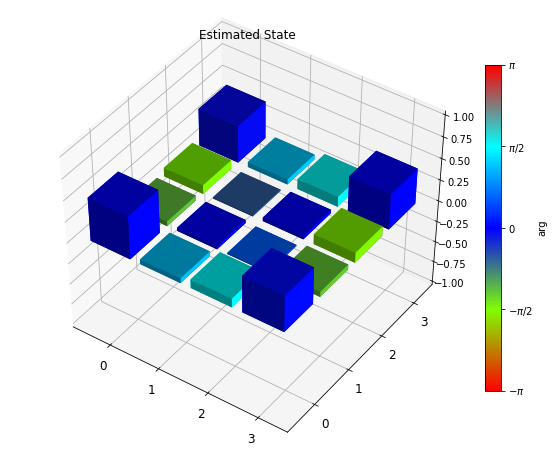

In [79]:
stomo2.plot();

Sampling bitstring preparations:
. . . . done.
Sampling tomographic measurements:
. . . . . . . . . . . . . . . . done.


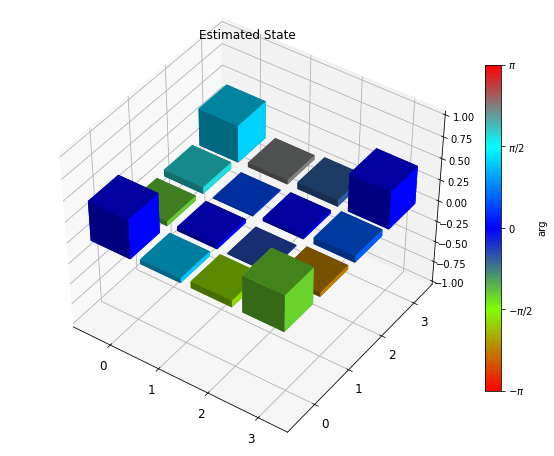

In [52]:
do_state_tomography(Program([H(0), 
                             H(1), CZ(0, 1), H(1)
                            ]), 2000, qpu2, [0, 1])

In [65]:
ptomo_qvm , _ = do_process_tomography(Program([CZ(0, 1)]), 10000, cxn, [0, 1])

Sampling bitstring preparations:
. . . . done.
Sampling tomographic measurements:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


(<grove.benchmarking.tomography.ProcessTomography at 0x113184610>,
 array([[ 1.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]]))

In [73]:
%%time
ptomo2, ap3 =  do_process_tomography(Program([CZ(0, 1)]), 10000, qpu, [0, 1])

Sampling bitstring preparations:
. . . . done.
Sampling tomographic measurements:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.
CPU times: user 2min 4s, sys: 3.79 s, total: 2min 8s
Wall time: 18min 47s


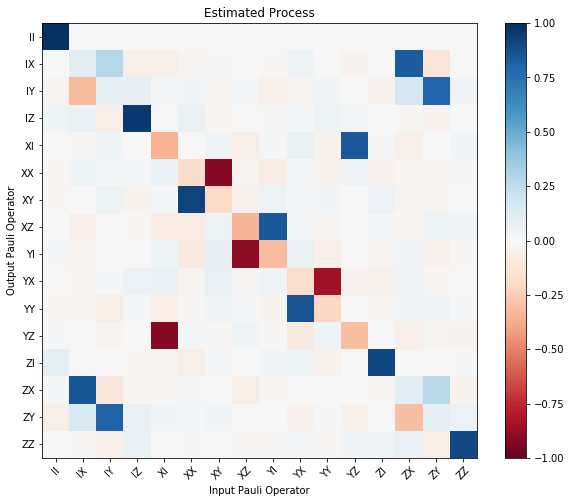

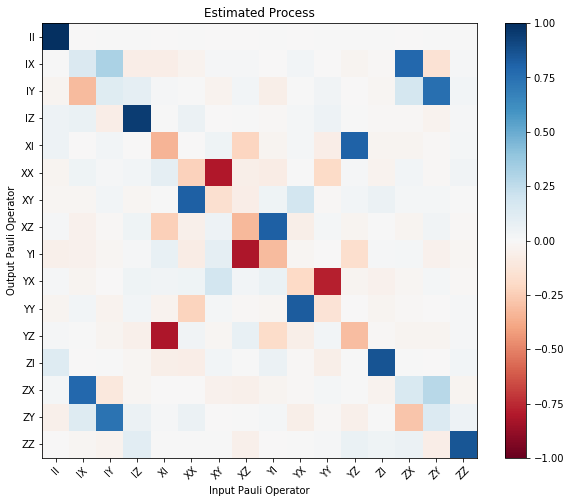

In [74]:
ptomo.plot();
ptomo2.plot();

In [ ]:
%%time
ptomo2, ap3 =  do_process_tomography(Program([CZ(0, 1)]), 10000, qpu, [0, 1])

In [75]:
ptomo2.avg_gate_fidelity_gate_fidelity(ptomo.R_est), ptomo_qvm.avg_gate_fidelity(ptomo.R_est), ptomo_qvm.avg_gate_fidelity(ptomo2.R_est)

(0.84988434982830297, 0.54047314522787093, 0.45778532712790143)

In [80]:
%%time
ptomo3, ap4 =  do_process_tomography(Program([CZ(0, 1)]), 2000, qpu, [0, 1])

Sampling bitstring preparations:
. . . . done.
Sampling tomographic measurements:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.
CPU times: user 18.9 s, sys: 1.23 s, total: 20.1 s
Wall time: 7min 17s


In [88]:
%%time
ptomo3, ap4 =  do_process_tomography(Program([CZ(0, 1)]), 4000, qpu, [0, 1])

Sampling bitstring preparations:
. . . . done.
Sampling tomographic measurements:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.
CPU times: user 28.9 s, sys: 1.66 s, total: 30.5 s
Wall time: 8min 28s


In [86]:
ptomo_qvm.avg_gate_fidelity(ptomo3.R_est)

0.90342554213823756

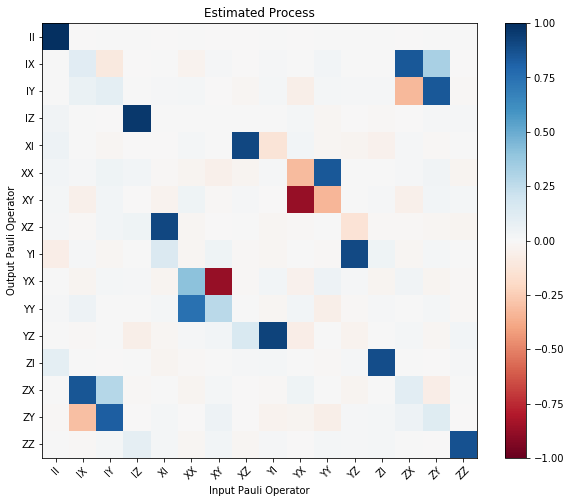

In [87]:
ptomo3.plot();

In [76]:
import sys
sys.path.append("/Users/nikolas/Projects/willow/")

# State tomography

0.994883733658
0.993701941694


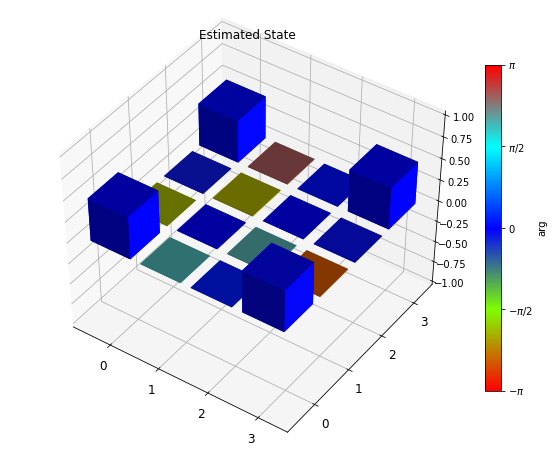

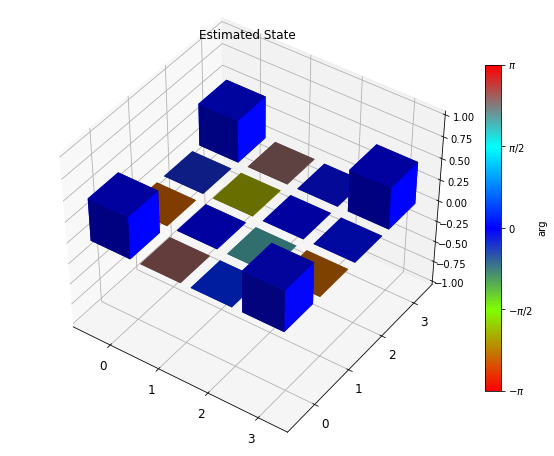

In [20]:
prog = Program([H(0),
                H(1),
                CZ(0, 1),
                H(1)])

nq = len(prog.extract_qubits())
d = 2 ** nq

tomo_seq = list(state_tomography_programs(prog))
nsamples = 3000

np.random.seed(234213)
state_prep_hists = [make_histogram(sample_bad_readout(p, 3*nsamples, BAD_2Q_READOUT, rcxn), d)
                    for p in basis_state_preps(*range(nq))]
assignment_probs = estimate_assignment_probs(state_prep_hists)

histograms = np.zeros((len(tomo_seq), d))

for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_2Q_READOUT, rcxn), d)

povm = make_diagonal_povm(POVM_PI_BASIS ** nq, assignment_probs)
channel_ops = list(default_channel_ops(nq))

rcxn.run(prog)
state = qt.Qobj(rcxn.wf, dims=[[2, 2], [1, 1]])
rho_ideal = state * state.dag()

for settings in [
    DEFAULT_STATE_TOMO_SETTINGS,
    DEFAULT_STATE_TOMO_SETTINGS._replace(constraints={'unit_trace', 'positive'})]:
    state_tomo = StateTomography.estimate_from_ssr(histograms, povm, channel_ops,
                                                   settings)
    state_tomo.plot()
    print state_tomo.fidelity(rho_ideal)


## Single qubit

/Users/nikolas/.virtualenvs/willowdev/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


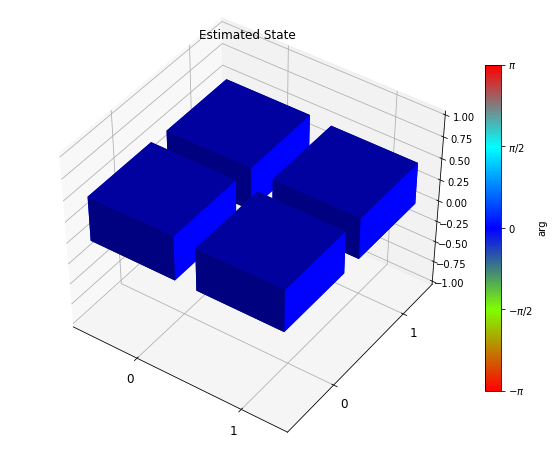

In [6]:
prog = Program(Gate("Y-HALF", (), [unpack_qubit(0)]))
nq = 1
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(state_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs([0], BAD_1Q_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_1Q_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
state_tomo = StateTomography.estimate_from_ssr(histograms, povm, channel_ops, DEFAULT_STATE_TOMO_SETTINGS)
state_tomo.plot();

## Two qubit GHZ

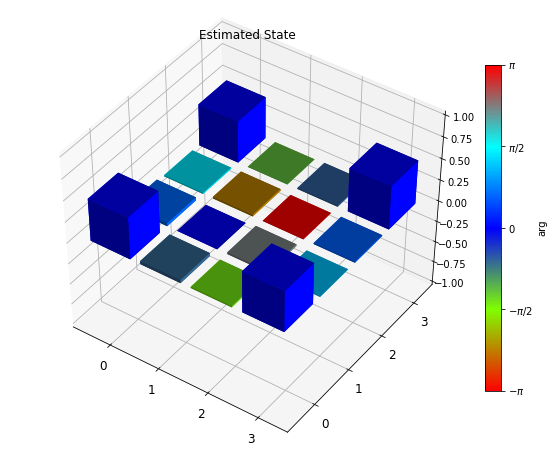

In [16]:
BAD_2Q_READOUT = np.kron(BAD_1Q_READOUT, BAD_1Q_READOUT)

prog = Program([H(0), 
                H(1),
                CZ(0, 1),
                H(1)])
nq = len(prog.extract_qubits())
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(state_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs([0, 1], BAD_2Q_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_2Q_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
state_tomo = StateTomography.estimate_from_ssr(histograms, povm, channel_ops, DEFAULT_STATE_TOMO_SETTINGS)
state_tomo.plot();

## N qubit GHZ

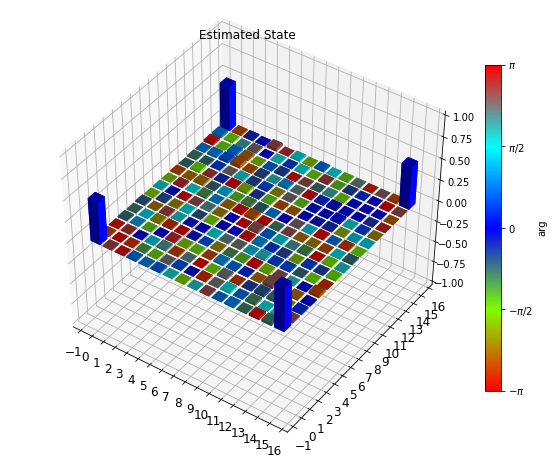

In [8]:
N = 4

BAD_NQ_READOUT = reduce(np.kron, [BAD_1Q_READOUT] * (N-1), BAD_1Q_READOUT)

prog = Program([H(0)] + [CNOT(j, j+1) for j in range(N-1)])
nq = len(prog.extract_qubits())
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(state_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs(range(N), BAD_NQ_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_NQ_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
state_tomo = StateTomography.estimate_from_ssr(histograms, povm, channel_ops, DEFAULT_STATE_TOMO_SETTINGS)
state_tomo.plot();

# Process tomography

## Single qubit

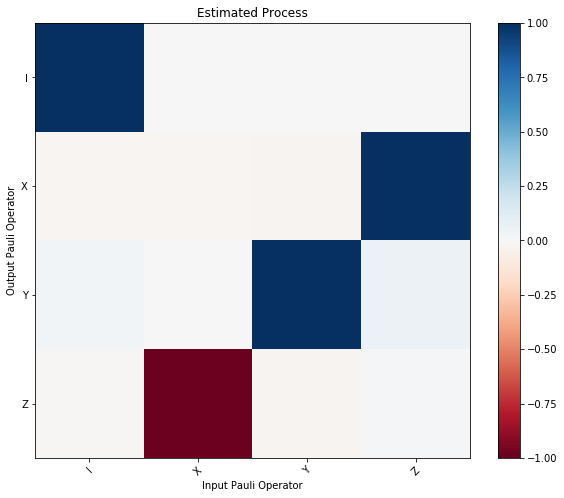

In [9]:
prog = Program(Gate("Y-HALF", (), [unpack_qubit(0)]))
nq = 1
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(process_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs([0], BAD_1Q_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_1Q_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
process_tomo = ProcessTomography.estimate_from_ssr(histograms, povm, channel_ops, channel_ops, DEFAULT_PROCESS_TOMO_SETTINGS)
process_tomo.plot();

## CZ process tomography

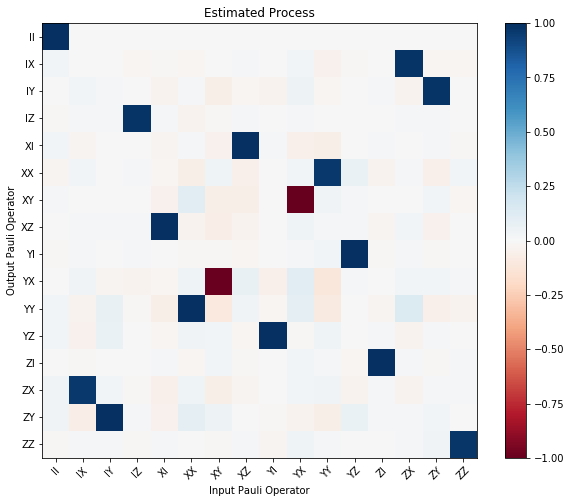

In [21]:
BAD_2Q_READOUT = np.kron(BAD_1Q_READOUT, BAD_1Q_READOUT)

prog = Program([CZ(0, 1)])
nq = len(prog.extract_qubits())
d = 2**nq
tomo_channels = list(default_rotations(*range(nq)))
tomo_seq = list(process_tomography_programs(prog))
nsamples = 1000

assignment_probs = estimate_assignment_probs([0, 1], BAD_2Q_READOUT, nsamples, cxn)

histograms = np.zeros((len(tomo_seq), d))
for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_2Q_READOUT, cxn), d)
    
povm = make_diagonal_povm(POVM_PI_BASIS**nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
process_tomo = ProcessTomography.estimate_from_ssr(histograms.reshape((len(tomo_channels), len(tomo_channels), d)), povm, channel_ops, channel_ops, DEFAULT_PROCESS_TOMO_SETTINGS)
process_tomo.plot();

In [19]:
prog = Program([
                CZ(0, 1),
                ])

nq = len(prog.extract_qubits())
d = 2 ** nq

tomo_channels = list(default_rotations(*range(nq)))

tomo_seq = list(process_tomography_programs(prog))
nsamples = 1000

assignment_probs = BAD_2Q_READOUT

histograms = np.zeros((len(tomo_seq), d))

for jj, p in enumerate(tomo_seq):
    histograms[jj] = make_histogram(sample_bad_readout(p, nsamples, BAD_2Q_READOUT, cxn), d)

histograms = histograms.reshape((len(tomo_channels), len(tomo_channels), d))

povm = make_diagonal_povm(POVM_PI_BASIS ** nq, assignment_probs)
channel_ops = [quil_to_operator(tomo_q) for tomo_q in tomo_channels]
process_tomo = ProcessTomography.estimate_from_ssr(histograms, povm, channel_ops, channel_ops,
                                               DEFAULT_PROCESS_TOMO_SETTINGS)

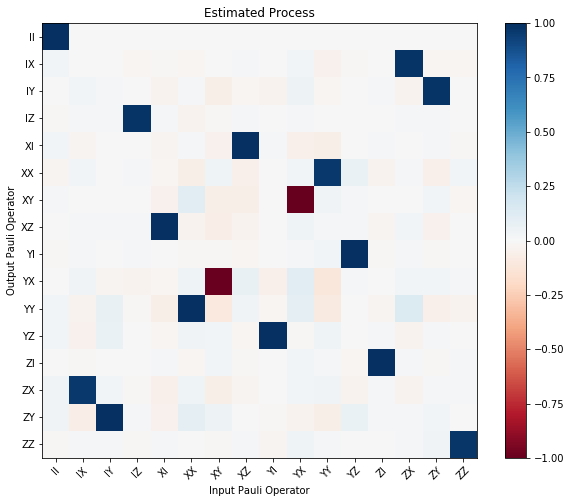

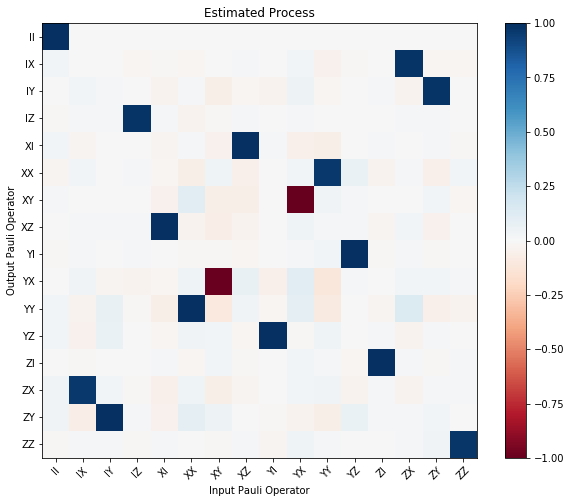

In [23]:
process_tomo.plot()

In [ ]:
TOMOGRAPHY_DEFCIRCUITS

In [33]:
TOMOGRAPHY_DEFCIRCUITS

In [34]:
prog = Program(TOMOGRAPHY_DEFCIRCUITS + [Gate("MINUS-X", (), [unpack_qubit(0)])
                ])

In [37]:
print prog.out()

DEFGATE X-HALF:
    0.70710678118654757+0.0i, 0.0-0.70710678118654757i
    0.0-0.70710678118654757i, 0.70710678118654757+0.0i

DEFGATE MINUS-Y-HALF:
    0.70710678118654757+0.0i, 0.70710678118654757+0.0i
    -0.70710678118654746+0.0i, 0.70710678118654757+0.0i

DEFGATE Y-HALF:
    0.70710678118654757+0.0i, -0.70710678118654757+0.0i
    0.70710678118654746+0.0i, 0.70710678118654757+0.0i

DEFGATE I:
    1.0+0.0i, 0.0+0.0i
    0.0+0.0i, 1.0+0.0i

DEFGATE MINUS-Y:
    0.0+0.0i, 1.0+0.0i
    -1.0+0.0i, 0.0+0.0i

DEFGATE MINUS-X-HALF:
    0.70710678118654757+0.0i, 0.0+0.70710678118654757i
    0.0+0.70710678118654757i, 0.70710678118654757+0.0i

DEFGATE Y:
    0.0+0.0i, -1.0+0.0i
    1.0+0.0i, 0.0+0.0i

DEFGATE X:
    0.0+0.0i, 0.0-1.0i
    0.0-1.0i, 0.0+0.0i

DEFGATE MINUS-X:
    0.0+0.0i, 0.0+1.0i
    0.0+1.0i, 0.0+0.0i

MINUS-X 0



In [43]:
hash(RX(np.pi/2))

292484537

In [27]:
cxn_cloud = CloudSyncConnection()

In [39]:
print prog

H 0
H 1
CZ 0 1
H 1



In [ ]:
cxn.run_and_measure

In [36]:
from pyquil.qpu import QPUConnection


In [37]:
qpu = QPUConnection()

In [40]:
num_shots = 2000  # the number of shots to take
qubits = [0, 1]  # the qubits to return results for (order matters; does not change the readout)
result = qpu.run_and_measure(prog, qubits, num_shots)

In [42]:
if result.is_done(): print result.result['result']

[[1, 1], [0, 0], [1, 1], [1, 1], [0, 0], [0, 0], [1, 1], [1, 1], [1, 0], [1, 0], [0, 0], [1, 0], [1, 1], [1, 1], [0, 0], [1, 1], [1, 1], [1, 1], [0, 0], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [0, 0], [1, 1], [1, 0], [0, 0], [1, 1], [0, 0], [1, 1], [0, 0], [0, 1], [1, 1], [0, 0], [1, 1], [0, 0], [1, 1], [1, 1], [0, 1], [0, 1], [1, 1], [0, 0], [0, 0], [0, 1], [0, 1], [1, 0], [0, 1], [1, 1], [0, 0], [0, 0], [1, 1], [0, 0], [1, 1], [1, 1], [0, 0], [0, 1], [1, 0], [0, 0], [0, 0], [1, 1], [0, 0], [1, 1], [0, 0], [0, 0], [1, 1], [0, 0], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [1, 1], [0, 0], [0, 0], [0, 0], [1, 1], [1, 0], [0, 0], [0, 0], [1, 0], [0, 0], [0, 0], [0, 1], [0, 0], [0, 0], [1, 1], [1, 0], [1, 1], [1, 1], [1, 1], [0, 1], [1, 1], [0, 0], [1, 1], [0, 0], [0, 0], [0, 0], [1, 1], [0, 0], [1, 1], [1, 1], [0, 0], [1, 1], [1, 1], [1, 1], [1, 0], [1, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [1, 1], [0, 0], [1, 1], [0, 0], [0, 0], [0, 0], [1, 1], [0, 0], [0, 0], [0, 0], [1, 1], [0, 0],